# Installs and Imports

In [1]:
# mounting drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/BullingerDigitalLMFootnotes/git_repo/evaluate


/content/drive/MyDrive/BullingerDigitalLMFootnotes/git_repo/evaluate


In [3]:
%pip install evaluate
%pip install transformers
%pip install bert-score
%pip install rouge_score

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=7ddc093719b7f292f5fa877f62e06a07a0188d6ed63a45fbe6f22ba6e71cfdea
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [4]:
from evaluate_utils import *
import pandas as pd
import os
def get_merged_df(human_df, machine_df, filepath):
  if os.path.exists(filepath):
    merged_df = pd.read_csv(filepath)
  else:
    merged_df = machine_df.merge(human_df, on=["letter_id", "n_footnote"])
    merged_df = merged_df[["letter_id", "n_footnote", "generated_footnote", "xml_footnote"]]
    merged_df.to_csv(filepath)
  return merged_df

pd.set_option('display.max_colwidth', None)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:

human_footnotes_df = pd.read_csv("../../data/footnote_downsized_df.csv")
human_footnotes_df["xml_footnote"] = human_footnotes_df["xml_footnote"].apply(remove_outer_note_tag)

In [6]:
model_name_map = {
    "llama-instruct": "Meta-Llama-3.1-8B-Instruct",
    "gpt-4o-mini": "gpt-4o-mini-2024-07-18",
    "gpt-4o": "gpt-4o-2024-08-06"
}


def average(df):
  columns = ["bleu_without", "rouge_without", "bert_without", "bleu_with", "rouge_with", "bert_with"]
  averages = []
  for col in columns:
    averages.append(df[col].mean())
  return averages

def compare(models:list[str], split:str, prompt):
  columns = ["bleu_without", "rouge_without", "bert_without", "bleu_with", "rouge_with", "bert_with"]
  results = {}
  for model in models:
    df = pd.read_csv(f"evaluation-{model_name_map[model]}_{prompt}_{split}.csv")
    results[model] = average(df)
  result_df = pd.DataFrame(columns=columns)
  for model in results:
    result_df.loc[model] = results[model]
  return result_df

# evaluation-Meta-Llama-3.1-8B-Instruct_instruct_add_test.csv

# Evaluate LLama Generation

## Instruct add

### example

In [ ]:
SPLIT = "example"
PROMPT = "instruct_add"
MODEL_NAME = "llama-instruct"

In [ ]:
df_filename = f"{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
generated_footnotes_df = pd.read_csv(f"../../data/model_responses/llama/{df_filename}")
eval_df_filename = f"evaluation-{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
merged_df = get_merged_df(human_footnotes_df, generated_footnotes_df, eval_df_filename)
evaluator = genEvaluator(merged_df)

bert_with is missing
bert_without is missing
No BLEU and ROUGE with markup are missing
No BLEU and ROUGE without are missing


In [ ]:
# no GPU
evaluator.compute_bleu_rouge()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

calculating BLEU and ROUGE with markup


100%|██████████| 74/74 [00:07<00:00,  9.39it/s]


In [ ]:
# with GPU
evaluator.compute_bertscore()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

Computing BERT with Mark-Up


100%|██████████| 74/74 [00:15<00:00,  4.79it/s]


Computing BERT without Markup


100%|██████████| 74/74 [00:13<00:00,  5.62it/s]


### test

In [10]:
SPLIT = "test"
PROMPT = "instruct_add"
MODEL_NAME = "llama-instruct"

In [11]:
df_filename = f"{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
generated_footnotes_df = pd.read_csv(f"../../data/model_responses/llama/{df_filename}")
eval_df_filename = f"evaluation-{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
merged_df = get_merged_df(human_footnotes_df, generated_footnotes_df, eval_df_filename)
evaluator = genEvaluator(merged_df)

In [ ]:
# no GPU
evaluator.compute_bleu_rouge_without_markup()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

In [ ]:
# with GPU
evaluator.compute_bertscore_without_markup()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

In [12]:
merged_df

,letter_id,n_footnote,generated_footnote,xml_footnote,bert_with,bert_without,bleu_with,rouge_with,bleu_without,rouge_without
0,12891,10,"Die drei Briefe, die ich empfangen habe, sind von dem König von Frankreich, dem König von England und dem König von Spanien.",1mm von einandren gan: Beim Auseinandergehen (nach der Sitzung).,0.623506,0.623506,0.000000,0.058824,0.0,0.058824
1,11456,3,Zu den Ammianischen Geschichten.,"<persName ref=""p8011"" cert=""high"">Gwalthers</persName> Brief an <persName ref=""p167"" cert=""high"">Johann Jakob Ammann</persName> ist nicht erhalten.",0.526715,0.644456,0.000000,0.000000,0.0,0.000000
2,10729,20,"1000 gl. verrösslet und nütt geschaffet, nämlich die Kosten für die Belagerung von <placeName ref=""l167"" cert=""high"">Jenff</placeName>.","<placeName ref=""l1280"" cert=""high"">Thonon (Chablais)</placeName>.",0.792157,0.604425,0.370373,0.312500,0.0,0.000000
3,12453,21,Von der Saxonischen und Lünenburgischen Gesandtschaft ist nichts zu hören.,"<persName ref=""p18509"" cert=""high"">Herzog August von Sachsen</persName>.",0.559318,0.665829,0.000000,0.090909,0.0,0.125000
4,12436,3,"Crediderim ergo non inconsultum fore, si ea hora tractarem historicum aliquid ex veteri testamento, vel Genesim vel quid aliud tale, s. <ref target=""file12377"">Nr. 2330</ref>, Anm. 14.",Gemeint ist: historicum librum.,0.603631,0.623745,0.000000,0.060606,0.0,0.068966
...,...,...,...,...,...,...,...,...,...,...
2868,13053,18,Malumus in acie cadere fortiter quam serviliter et turpiter subiacere libidini impii militis.,"Vgl. etwa <bibl>HBBW</bibl> XIX 240,38f. - Hier liegt eine Pointe gegen die Reichsstädte vor. Vgl. auch <ref target=""file13057"">Nr. 3008</ref>,[5].",0.522203,0.556036,0.000000,0.000000,0.0,0.000000
2869,11455,11,"Cęterum, quid nostri responderint, similiter accipe: „Neminem iustum possessorem unquam deiecimus, et sunt bona ecclesiastica bona ex parte nostra.“ (s. oben <ref target=""file11447"">Nr. 1404</ref>, S. 4).","Vgl. <bibl>ADRG</bibl> I/I 114-128, Nr. 29 (bes. S. 120, 20-127, 37); <bibl>PC</bibl> III 81.",0.589988,0.611891,0.000000,0.078431,0.0,0.093023
2870,11535,2,"""Quorsum enim, mi ter mihi venerande atque charissime Bullingere, attinet tantas pro tantilla re gratias agere, mihi praesertim, qui tot tibi nominibus, quod serio scribo, devinctus sum..."".","Siehe oben <ref target=""file11520"">Nr. 1477</ref>, 2-5.",0.507285,0.517042,0.000000,0.000000,0.0,0.000000
2871,12823,28,"Ich bin gar angsthafft in der sach, weil der Kurfürst von Augsburg und der Landgraf von Hessen sich rüsten, um gegen die Eidgenossen und den Franzosen zu kämpfen, und ich fürchte, dass dies zu einem blutigen Konflikt führen wird.",besorgt; s. <hi>FNHDW</hi> I 1197f.,0.528882,0.550350,0.000000,0.000000,0.0,0.000000


### dev set


In [13]:
SPLIT = "dev"
PROMPT = "instruct_add"
MODEL_NAME = "llama-instruct"

In [11]:
df_filename = f"{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
generated_footnotes_df = pd.read_csv(f"../../data/model_responses/llama/{df_filename}")
eval_df_filename = f"evaluation-{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
merged_df = get_merged_df(human_footnotes_df, generated_footnotes_df, eval_df_filename)
evaluator = genEvaluator(merged_df)

In [10]:
# no GPU
evaluator.compute_bleu_rouge_with_markup()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

calculating BLEU and ROUGE with markup


100%|██████████| 2585/2585 [04:30<00:00,  9.54it/s]


In [10]:
# with GPU
evaluator.compute_bertscore()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

Computing BERT with Mark-Up


  0%|          | 0/2585 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

100%|██████████| 2585/2585 [00:47<00:00, 53.94it/s]


Computing BERT without Markup


100%|██████████| 2585/2585 [00:23<00:00, 111.41it/s]


In [14]:
merged_df

,letter_id,n_footnote,generated_footnote,xml_footnote,bert_with,bert_without,bleu_with,rouge_with,bleu_without,rouge_without
0,12891,10,"Die drei Briefe, die ich empfangen habe, sind von dem König von Frankreich, dem König von England und dem König von Spanien.",1mm von einandren gan: Beim Auseinandergehen (nach der Sitzung).,0.623506,0.623506,0.000000,0.058824,0.0,0.058824
1,11456,3,Zu den Ammianischen Geschichten.,"<persName ref=""p8011"" cert=""high"">Gwalthers</persName> Brief an <persName ref=""p167"" cert=""high"">Johann Jakob Ammann</persName> ist nicht erhalten.",0.526715,0.644456,0.000000,0.000000,0.0,0.000000
2,10729,20,"1000 gl. verrösslet und nütt geschaffet, nämlich die Kosten für die Belagerung von <placeName ref=""l167"" cert=""high"">Jenff</placeName>.","<placeName ref=""l1280"" cert=""high"">Thonon (Chablais)</placeName>.",0.792157,0.604425,0.370373,0.312500,0.0,0.000000
3,12453,21,Von der Saxonischen und Lünenburgischen Gesandtschaft ist nichts zu hören.,"<persName ref=""p18509"" cert=""high"">Herzog August von Sachsen</persName>.",0.559318,0.665829,0.000000,0.090909,0.0,0.125000
4,12436,3,"Crediderim ergo non inconsultum fore, si ea hora tractarem historicum aliquid ex veteri testamento, vel Genesim vel quid aliud tale, s. <ref target=""file12377"">Nr. 2330</ref>, Anm. 14.",Gemeint ist: historicum librum.,0.603631,0.623745,0.000000,0.060606,0.0,0.068966
...,...,...,...,...,...,...,...,...,...,...
2868,13053,18,Malumus in acie cadere fortiter quam serviliter et turpiter subiacere libidini impii militis.,"Vgl. etwa <bibl>HBBW</bibl> XIX 240,38f. - Hier liegt eine Pointe gegen die Reichsstädte vor. Vgl. auch <ref target=""file13057"">Nr. 3008</ref>,[5].",0.522203,0.556036,0.000000,0.000000,0.0,0.000000
2869,11455,11,"Cęterum, quid nostri responderint, similiter accipe: „Neminem iustum possessorem unquam deiecimus, et sunt bona ecclesiastica bona ex parte nostra.“ (s. oben <ref target=""file11447"">Nr. 1404</ref>, S. 4).","Vgl. <bibl>ADRG</bibl> I/I 114-128, Nr. 29 (bes. S. 120, 20-127, 37); <bibl>PC</bibl> III 81.",0.589988,0.611891,0.000000,0.078431,0.0,0.093023
2870,11535,2,"""Quorsum enim, mi ter mihi venerande atque charissime Bullingere, attinet tantas pro tantilla re gratias agere, mihi praesertim, qui tot tibi nominibus, quod serio scribo, devinctus sum..."".","Siehe oben <ref target=""file11520"">Nr. 1477</ref>, 2-5.",0.507285,0.517042,0.000000,0.000000,0.0,0.000000
2871,12823,28,"Ich bin gar angsthafft in der sach, weil der Kurfürst von Augsburg und der Landgraf von Hessen sich rüsten, um gegen die Eidgenossen und den Franzosen zu kämpfen, und ich fürchte, dass dies zu einem blutigen Konflikt führen wird.",besorgt; s. <hi>FNHDW</hi> I 1197f.,0.528882,0.550350,0.000000,0.000000,0.0,0.000000


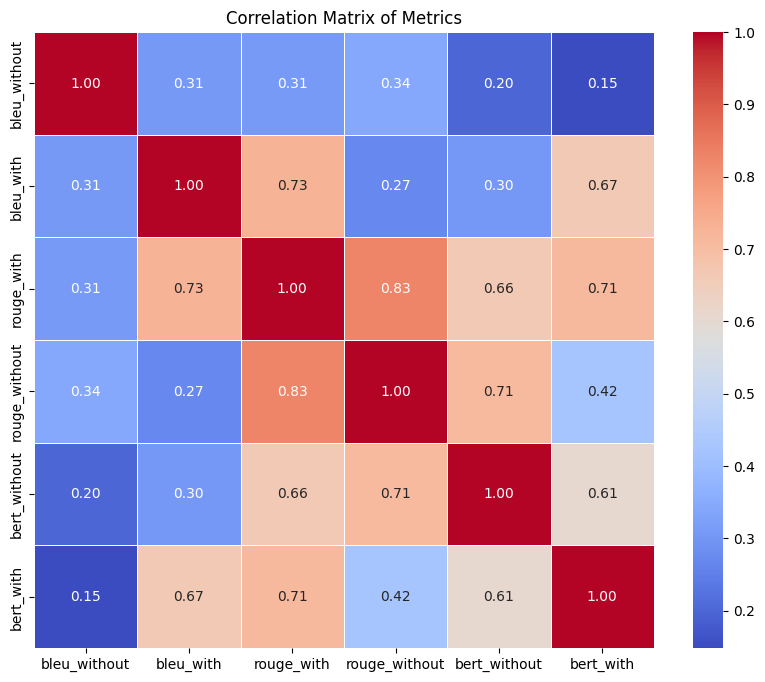

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the correlation matrix
correlation_matrix = merged_df[['bleu_without', 'rouge_without', 'bert_without', "bert_with", "bleu_with", "rouge_with"]].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Metrics')
plt.show()

## instruct QA

### example

In [9]:
SPLIT = "example"
PROMPT = "instruct_qa"
MODEL_NAME = "llama-instruct"

In [10]:
df_filename = f"{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
generated_footnotes_df = pd.read_csv(f"../../data/model_responses/llama/{df_filename}")
eval_df_filename = f"evaluation-{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
merged_df = get_merged_df(human_footnotes_df, generated_footnotes_df, eval_df_filename)
evaluator = genEvaluator(merged_df)

In [11]:
# no GPU
evaluator.compute_bleu_rouge()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

calculating BLEU and ROUGE with markup


100%|██████████| 38/38 [00:03<00:00, 10.47it/s]


calculating BLEU and ROUGE without markup


100%|██████████| 38/38 [00:04<00:00,  8.87it/s]


In [12]:
# with GPU
evaluator.compute_bertscore()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

Computing BERT with Mark-Up


  0%|          | 0/38 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

100%|██████████| 38/38 [00:16<00:00,  2.37it/s]


Computing BERT without Markup


100%|██████████| 38/38 [00:03<00:00, 11.81it/s]


# Evaluate GPT 4o-mini generation
Note that for the filename creation here, '-' is used instead of '_'<br>
Is this optimal? No! but too late to change...

## Instruct add

### example

In [ ]:
SPLIT = "example"
PROMPT = "instruct_add"
MODEL_NAME = "gpt-4o-mini"

In [ ]:
df_filename = f"{model_name_map[MODEL_NAME]}-{PROMPT}-{SPLIT}.csv"
generated_footnotes_df = pd.read_csv(f"../../data/model_responses/gpt/{df_filename}")
eval_df_filename = f"evaluation-{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
merged_df = get_merged_df(human_footnotes_df, generated_footnotes_df, eval_df_filename)
evaluator = genEvaluator(merged_df)

bert_with is missing
bert_without is missing
No BLEU and ROUGE with markup are missing
No BLEU and ROUGE without are missing


In [ ]:
# no GPU
evaluator.compute_bleu_rouge()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

calculating BLEU and ROUGE with markup


100%|██████████| 74/74 [00:08<00:00,  9.00it/s]

calculating BLEU and ROUGE without markup



100%|██████████| 74/74 [00:07<00:00,  9.65it/s]


In [ ]:
# with GPU
evaluator.compute_bertscore()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

Computing BERT with Mark-Up


  0%|          | 0/74 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

100%|██████████| 74/74 [00:22<00:00,  3.32it/s]


Computing BERT without Markup


100%|██████████| 74/74 [00:12<00:00,  6.13it/s]


### dev

In [ ]:
SPLIT = "dev"
PROMPT = "instruct_add"
MODEL_NAME = "gpt-4o-mini"

In [ ]:
df_filename = f"{model_name_map[MODEL_NAME]}-{PROMPT}-{SPLIT}.csv"
generated_footnotes_df = pd.read_csv(f"../../data/model_responses/gpt/{df_filename}")
eval_df_filename = f"evaluation-{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
merged_df = get_merged_df(human_footnotes_df, generated_footnotes_df, eval_df_filename)
evaluator = genEvaluator(merged_df)

In [ ]:
# no GPU
evaluator.compute_bleu_rouge_with_markup()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

calculating BLEU and ROUGE with markup


100%|██████████| 3126/3126 [05:13<00:00,  9.96it/s]


In [ ]:
# with GPU
evaluator.compute_bertscore()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

Computing BERT with Mark-Up


  0%|          | 0/3126 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

100%|██████████| 3126/3126 [01:02<00:00, 50.06it/s]


Computing BERT without Markup


100%|██████████| 3126/3126 [00:39<00:00, 79.35it/s]


In [ ]:
merged_df

,letter_id,n_footnote,generated_footnote,xml_footnote,bleu_without,rouge_without,bert_with,bert_without,bleu_with,rouge_with
0,10043,12,"In der Fußnote n=12 könnte folgender Text stehen:\n\n„Zuinglius (Huldrych Zwingli, 1484–1531) war ein wichtiger Reformator der Schweiz und zeitgenössischer Kollege von Bullinger. Seine theologischen Ansichten und seine Rolle bei der Reformation in Zürich hatten erheblichen Einfluss auf die Entwicklung der reformierten Tradition. Es ist bedeutsam, dass Bullinger ihn in diesem Brief erwähnt, was die enge Verbindung und den Austausch zwischen diesen führenden reformatorischen Persönlichkeiten unterstreicht.“","Siehe oben S. 67, Anm. 6.",0.0,0.000000,0.555410,0.555410,0.000000,0.000000
1,10043,7,"Lactantius (Lucius Caecilius Firmianus Lactantius) war ein frühchristlicher Schriftsteller und Philosoph des 3. und 4. Jahrhunderts n. Chr., dessen Werke oft im Kontext der apologetischen Literatur zitiert werden. In seinem Werk „De vero cultu“ (Über die wahre Anbetung) kritisiert er die heidnischen Praktiken und betont die Wichtigkeit einer wahren, der christlichen Lehre entsprechenden Gottesdienstes. Insbesondere Kapitel 25 behandelt die Absurditäten und Ungerechtigkeiten, die durch falsche Anbetung und Götzendienst entstehen, was Bullinger in seinem Brief als relevante Argumentation gegen die Missstände seiner Zeit heranzieht.","<persName ref=""p19001"" cert=""high"">Laktanz</persName>, Divinae institutiones, lib. VI: «De vero cultu», 25 (<bibl>CSEL</bibl> XIX 577-580).",0.0,0.080000,0.572689,0.613352,0.000000,0.074074
2,10043,8,"Die Erwähnung von ""Thrasonis"" bezieht sich auf den antiken Charakter Thrasonides aus den Komödien des römischen Dichters Plautus, der für seine Prahlerei bekannt ist. Bullinger verwendet hier den Namen symbolisch, um die Arroganz und Heuchelei der damaligen religiösen Führer zu kritisieren, die sich durch ihre Ansprüche an die Wahrheit und den Glauben auszeichnen, während sie in Wirklichkeit von Ungerechtigkeit und Sünde durchdrungen sind.","Thraso ist der Name des prahlerischen Soldaten im Eunuchus des <persName ref=""p18901"" cert=""high"">Terenz</persName>, s. <bibl>Adagia</bibl>, prolegomena (<bibl>LB</bibl> II 13 B).",0.0,0.088889,0.577145,0.619363,0.000000,0.080000
3,10043,9,"Die Bezeichnung „harpigiis“ bezieht sich auf die damals verbreitete Auffassung, dass Papisten und ihre Praktiken als räuberisch oder schädlich angesehen wurden, ähnlich wie das Bild von Räubern oder Schurken. Es könnte hier auch auf die Vorstellung anspielen, dass solche Personen (Harpien) die Gläubigen ausrauben und ihnen das wahre Verständnis des Glaubens vorenthalten.","harpigium, Nebenform zu harpago.",0.0,0.000000,0.623556,0.623556,0.000000,0.000000
4,10047,3,"Hier bezieht sich Leo Jud auf Luthers eigene Schwierigkeiten bei der Auslegung bestimmter biblischer Passagen, insbesondere im Hinblick auf die dogmatischen Differenzen zwischen der lutherischen und der reformierten Theologie. Luther hatte vor allem in seinen Schriften in den 1520er Jahren betont, dass es einige Stellen in den Schriften der Propheten oder den Aposteln gebe, die er nicht vollständig begreifen könne, was auf die Komplexität der theologischen Diskussionen in dieser Zeit hinweist. Diese Bemerkung ist sowohl eine Selbstkritik als auch ein Hinweis auf die Herausforderungen der theologischen Auseinandersetzung während der Reformation.","Vgl. WA XII 367, 27-31.",0.0,0.000000,0.543293,0.543293,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
3121,13134,7,"<note>Die Bezeichnung ""botten"" deutet auf ein gesandtes Schreiben oder einen Boten hin, der Nachrichten weitergab. In der Reformierten Kirche und unter Freunden wurden oft Boten eingesetzt, um Informationen zu übermitteln oder Briefe zu überbringen. Dies zeigt die Vernetzung zwischen den reformatorischen Persönlichkeiten und deren strategische Kommunikation.</note>","Die hiernach genannten Gesandten <persName ref=""p6793"" cert=""high"">Itelhans Thumysen</persNa

### test

In [ ]:
SPLIT = "test"
PROMPT = "instruct_add"
MODEL_NAME = "gpt-4o-mini"

In [ ]:
df_filename = f"{model_name_map[MODEL_NAME]}-{PROMPT}-{SPLIT}.csv"
generated_footnotes_df = pd.read_csv(f"../../data/model_responses/gpt/{df_filename}")
eval_df_filename = f"evaluation-{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
merged_df = get_merged_df(human_footnotes_df, generated_footnotes_df, eval_df_filename)
evaluator = genEvaluator(merged_df)

In [ ]:
merged_df

,letter_id,n_footnote,generated_footnote,xml_footnote,text_footnote,bert_with,bert_without,bleu_with,rouge_with,bleu_without,rouge_without
0,10038,10,"Die Frage, warum Christus nicht sofort nach seiner ersten Verheißung auf Erden erschienen ist, reflektiert eine theologische Debatte über das Wesen des göttlichen Plans und die Zeitlichkeit der Erlösung. In der christlichen Tradition wird häufig auf die Notwendigkeit verwiesen, dass das Kommen Christi in die Welt einen bestimmten göttlichen Zeitrahmen erfordert, der das Verständnis des Menschen überschreitet. Die erwähnten prophetischen Voraussagen bieten einen weiteren Kontext, um die Diskrepanz zwischen irdischem Leiden und göttlicher Erfüllung in der Heilsgeschichte zu interpretieren. Betrachtet man die Schriften des Neuen Testaments, insbesondere die Evangelien, wird deutlich, dass die zeitliche Offenbarung des Christus immer in Verbindung mit dem göttlichen Willen und dem Heilsplan steht.","<persName ref=""p18700"" cert=""high"">Augustin</persName>, ep. XCIII, 35 (<bibl>CSEL</bibl> XXXIIII 480, 9ff), u. ö.","Augustin, ep. XCIII, 35 (CSEL XXXIIII 480, 9ff), u. ö.",0.502305,0.530336,0.000000,0.000000,0.0,0.000000
1,10038,11,"Der Hinweis auf Mose bezieht sich auf dessen Rolle als Prophet und Führer des Volkes Israel, das aus der ägyptischen Sklaverei befreit wurde. Die Referenz zu den Propheten kann auch die Erwartungen der Reformatoren widerspiegeln, die die Rückkehr zu einer ersten, unverdorbenen Form der Glaubensausübung forderten. Sie beziehen sich auf das biblische Verständnis von Offenbarung, das den Propheten (Mose und Paulus) als Vorbilder im Glauben sieht und deren Autorität zur Interpretation des göttlichen Willens betont.","Vgl. <cit type=""bible""><ref>Dtn 18,15ff</ref></cit>.","Vgl. Dtn 18,15ff.",0.522886,0.534127,0.000000,0.000000,0.0,0.000000
2,10038,12,"Die Frage nach dem Plan Gottes wird oft in der Theologie diskutiert. Bullinger deutet hier an, dass die Vorgaben der göttlichen Vorsehung und die Art und Weise, wie sie sich im Lauf der Geschichte entfalten, einen bestimmten Zweck haben, der oft schwer zu verstehen ist. So lässt sich auf Johannes Chrysostomus verweisen, der in seinen Schriften darauf hinweist, dass die Notwendigkeit des göttlichen Willens nicht immer für den Menschen erkennbar ist (vgl. ""In Matthaeum"", Homilie 19).","Vgl. <cit type=""bible""><ref>1 Kor 12, 10.28</ref></cit>; <cit type=""bible""><ref>14,3ff</ref></cit>, u. ö.","Vgl. 1 Kor 12, 10.28; 14,3ff, u. ö.",0.530798,0.560888,0.000000,0.019802,0.0,0.022472
3,10038,13,"In Anlehnung an die biblische Tradition spricht Bullinger hier die Idee an, dass die Propheten ""befreit"" wurden, um den Willen Gottes zu offenbaren und die Menschen auf den richtigen Weg zu führen. Der Verweis auf die ""deploratissimi"" Zustand der Menschen unter dem ""impiissimo Antichristi regno"" könnte auf die allgemeine Unzufriedenheit mit der religiösen Situation seiner Zeit hinweisen, insbesondere im Kontext der Reformation, bei der die Autorität der Kirche hinterfragt wurde. Bullinger drückt damit den Wunsch aus, die göttliche Wahrheit in einer Zeit der Verwirrung wiederherzustellen und die Menschen zu motivieren, Gott und seiner Botschaft treu zu bleiben.","<cit type=""bible""><ref>1 Joh 4,1</ref></cit>.","1 Joh 4,1.",0.530286,0.526090,0.000000,0.000000,0.0,0.000000
4,10038,14,"Die Betonung der göttlichen Inspiration und der prophetischen Freiheit, die im neuen Testament gefördert wird, zeigt sich besonders in <persName ref=""p1043"" cert=""high"">Johannes</persName> 1, 4-10 und <persName ref=""p18700"" cert=""high"">Paulus</persName> in seinem ersten Brief an die Thessalonicher 5, 20-21, wo das Prüfen aller Geister gefordert wird.<note xml:id=""fn14"" type=""footnote"" n=""14""></note>","<cit type=""bible""><ref>1 Thess 5,19-20</ref></cit>.","1 Thess 5,19-20.",0.698441,0.677590,0.000000,0.155844,0.0,0.120000
...,...,...,...,...,...,...,...,...,...,...,...
3234,13141,41,"<note xml:id=""fn41"" type=""footnote"" n="

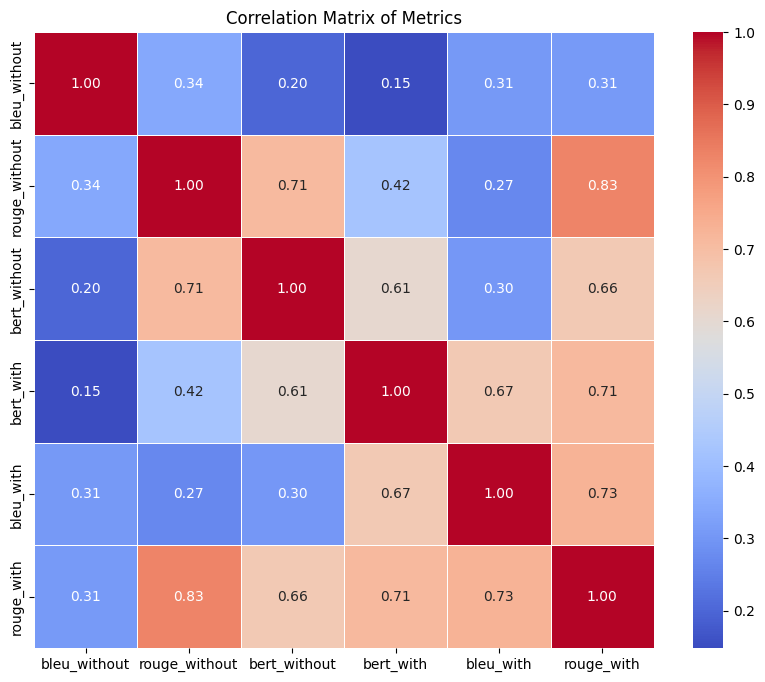

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the correlation matrix
correlation_matrix = merged_df[['bleu_without', 'rouge_without', 'bert_without', "bert_with", "bleu_with", "rouge_with"]].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Metrics')
plt.show()

## instruct QA

### example

In [7]:
SPLIT = "example"
PROMPT = "instruct_qa"
MODEL_NAME = "gpt-4o-mini"

In [8]:
df_filename = f"{model_name_map[MODEL_NAME]}-{PROMPT}-{SPLIT}.csv"
generated_footnotes_df = pd.read_csv(f"../../data/model_responses/gpt/{df_filename}")
eval_df_filename = f"evaluation-{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
merged_df = get_merged_df(human_footnotes_df, generated_footnotes_df, eval_df_filename)
evaluator = genEvaluator(merged_df)

In [ ]:
# no GPU
evaluator.compute_bleu_rouge()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

calculating BLEU and ROUGE with markup


100%|██████████| 112/112 [00:12<00:00,  9.26it/s]

calculating BLEU and ROUGE without markup



100%|██████████| 112/112 [00:11<00:00,  9.64it/s]


In [ ]:
# with GPU
evaluator.compute_bertscore()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

Computing BERT with Mark-Up


100%|██████████| 112/112 [00:30<00:00,  3.72it/s]


Computing BERT without Markup


100%|██████████| 112/112 [00:17<00:00,  6.53it/s]


In [9]:
merged_df

,letter_id,n_footnote,generated_footnote,xml_footnote,bleu_with,rouge_with,bleu_without,rouge_without,bert_with,bert_without
0,11298,11,"Johannes Buchser, ein reformierter Theologe und einer der Mitstreiter von Heinrich Bullinger, war aktiv in der Förderung der reformatorischen Prinzipien in der Schweiz. In diesem Kontext ist er relevant, da seine Zusammenarbeit mit anderen Reformatoren und sein Einfluss auf die Gemeinden in der Region während der Reformation bedeutend waren. Sein Verhältnis zu dem auch genannten Ioannis Surani weist auf eine enge Verbindung innerhalb des reformierten geistlichen Netzwerks hin, die für die Verbreitung reformatorischer Ideen und die Organisation der reformierten Kirche in der Region von Bedeutung war.","<persName ref=""p261"" cert=""high"">Johannes Buchser</persName>, Pfarrer in <placeName ref=""l497"" cert=""high"">Suhr</placeName> (Kt. Aargau). - <persName ref=""p8364"" cert=""high"">Gering</persName> war 1538 vom Zürcher Ehegericht von dessen Schwester <persName ref=""p4928"" cert=""high"">Sabinella</persName> geschieden worden (vgl. Zürich SIA, YY 1. 5, S. 1026f, und Zürich ZB, Ms F 154, Nr. 5).",0.0,0.092105,0.0,0.109375,0.559381,0.615874
1,11298,12,"Wilhelm von Fürstenberg (*circa 1480–1559) war ein bedeutender deutscher Adeliger und ein wichtiger Unterstützer der Reformbewegung im 16. Jahrhundert. Als Graf und Komtur des Johanniterordens spielte er eine zentrale Rolle in der Verwaltung und politischen Landschaft der Region Gengenbach, die damals als strategisch wichtig galt. Unter seiner Herrschaft wurde Gengenbach zu einem Ort, der sowohl für den politischen als auch für den religiösen Diskurs von Bedeutung war, insbesondere im Kontext der Auseinandersetzungen zwischen reformierten und katholischen Kräften im Heiligen Römischen Reich.","<persName ref=""p7492"" cert=""high"">Wilhelm von Fürstenberg</persName> verwaltete <placeName ref=""l1720"" cert=""high"">Gengenbach</placeName> als Pfandherr; vgl. Johannes Volker <hi>Wagner,</hi> Graf <persName ref=""p7492"" cert=""high"">Wilhelm von Fürstenberg</persName>, 1491-1549, und die politischgeistigen Mächte seiner Zeit, Stuttgart 1966. - Pariser Historische Studien, 4, S. 185f.",0.0,0.167832,0.0,0.195122,0.567983,0.629983
2,11298,3,"Siehe hierzu auch Johannes Calvin, *Institutio Christianae Religionis*, Buch 2, Kapitel 8, wo die Gefahren der Nachlässigkeit in der Seelsorge thematisiert werden; sowie Martin Luther, *Von der Freiheit eines Christenmenschen*, 1520, in dem er die Bedeutung der Wachsamkeit im Glauben hervorhebt. Des Weiteren behandeln die *Confessio Augustana*, Artikel 12, und die Schriften von Philipp Melanchthon das Thema der Sorgfalt und deren Einfluss auf das christliche Leben.",Vgl. ebd. 19-30.,0.0,0.000000,0.0,0.000000,0.556883,0.556883
3,11298,4,"In diesem Kontext bezieht sich die ""ecclesiola huius agri"" auf die reformierten Gemeinden in der Region Zürich, zu denen unter anderem die Stadtgemeinde Zürich sowie angrenzende ländliche Gemeinden wie Winterthur, Baden und andere gehörten, die während der Reformation unter Bullingers Einfluss standen. Diese Gemeinden standen in engem Kontakt und Austausch, insbesondere durch die gemeinsamen kirchlichen und theologischen Anliegen der Reformatoren.","Die Kirche bestand aus den Gemeinden der Herrschaften <placeName ref=""l221"" cert=""high"">Horburg</placeName> und <placeName ref=""l411"" cert=""high"">Reichenweier</placeName>, denen <persName ref=""p1010"" cert=""high"">Erb</persName> als Superintendent vorstand; vgl. Johann <hi>Adam,</hi> Evangelische Kirchengeschichte der elsässischen Territorien bis zur französischen Revolution, Straßburg 1928, S. 297.",0.0,0.100000,0.0,0.120000,0.585560,0.648178
4,11298,5,"Der Gedanke an ""Hoffnung gegen Hoffnung"" könnte biblisch in Römer 4,18 verankert sein, wo Abraham trotz widriger Umstände an die Verheißung Gottes glaubte. Auch Hebräer 11,1, das den Glauben als ""die Substanz der Dinge, die man hofft"" beschreibt, spiegelt diesen Gedank

### dev

In [ ]:
SPLIT = "dev"
PROMPT = "instruct_qa"
MODEL_NAME = "gpt-4o-mini"

In [ ]:
df_filename = f"{model_name_map[MODEL_NAME]}-{PROMPT}-{SPLIT}.csv"
generated_footnotes_df = pd.read_csv(f"../../data/model_responses/gpt/{df_filename}")
eval_df_filename = f"evaluation-{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
merged_df = get_merged_df(human_footnotes_df, generated_footnotes_df, eval_df_filename)
evaluator = genEvaluator(merged_df)

bert_with is missing
bert_without is missing


In [ ]:
# no GPU
evaluator.compute_bleu_rouge()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

calculating BLEU and ROUGE with markup


100%|██████████| 3145/3145 [05:17<00:00,  9.92it/s]

calculating BLEU and ROUGE without markup



100%|██████████| 3145/3145 [05:16<00:00,  9.94it/s]


In [ ]:
# with GPU
evaluator.compute_bertscore()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

Computing BERT with Mark-Up


  0%|          | 0/3145 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

100%|██████████| 3145/3145 [00:58<00:00, 53.90it/s]


Computing BERT without Markup


100%|██████████| 3145/3145 [00:38<00:00, 81.78it/s]


In [ ]:
merged_df

,letter_id,n_footnote,generated_footnote,xml_footnote,bleu_with,rouge_with,bleu_without,rouge_without,bert_with,bert_without
0,10043,12,"In Anmerkung 6 auf Seite 67 finden sich Informationen über die theologischen Positionen und Reformideen von Ulrich Zwingli, insbesondere seine Ansichten zur Eucharistie, seiner Rolle in der Zürcher Reformation sowie eine kurze biografische Skizze, die sowohl seine frühen Einflüsse als auch seine Konflikte mit Vertretern der lutherischen Lehre beleuchtet. Außerdem wird auf die Bedeutung seines Beitrags zur Reformbewegung im Kontext der religiösen und politischen Entwicklungen in der Schweiz eingegangen.","Siehe oben S. 67, Anm. 6.",0.000000,0.050000,0.000000,0.050000,0.604749,0.604749
1,10043,7,"Die zitierten Werke von Lactantius beziehen sich auf seine Schrift „Divinae Institutiones“ (Göttliche Institutionen), insbesondere auf Buch VI, Kapitel 25. In diesem Abschnitt behandelt Lactantius den „wahren Gottesdienst“ und kritisiert die Abgötterei sowie die Sünden, die im Namen falscher Kulte begangen werden. Diese Quelle liefert wertvolle Einsichten in die frühen christlichen Ansichten über Religion und Ethik und wird oft in theologischen Diskussionen zitiert.","<persName ref=""p19001"" cert=""high"">Laktanz</persName>, Divinae institutiones, lib. VI: «De vero cultu», 25 (<bibl>CSEL</bibl> XIX 577-580).",0.000000,0.090909,0.000000,0.100000,0.597479,0.644499
2,10043,8,"Im Kontext des Textes steht der Name ""Thraso"" symbolisch für eine prahlerische und spöttische Haltung. Thraso ist eine Figur aus dem Werk des römischen Dramatikers Terenz, die oft als Inbegriff des Wichtigtuers und Angeber dargestellt wird. Hier wird er als Beispiel für die Vortäuschung von Tugend und Religiosität genannt, während in Wahrheit eine Impietät und Heuchlerei vorherrscht, die die Unschuldigen verfolgt und die Kirche erdrosselt.","Thraso ist der Name des prahlerischen Soldaten im Eunuchus des <persName ref=""p18901"" cert=""high"">Terenz</persName>, s. <bibl>Adagia</bibl>, prolegomena (<bibl>LB</bibl> II 13 B).",0.000000,0.158416,0.000000,0.175824,0.607129,0.664514
3,10043,9,"Das Wort ""harpigium"" bezeichnet ein Werkzeug oder ein Gerät zum Greifen bzw. Einfangen, häufig im Kontext von Raub oder Diebstahl. Im Kontext des Satzes deutet es auf die mit Gewalt oder List verbundenen Mittel hin, die von den ""Papisten"" verwendet werden, um unrechtmäßig Besitz von den Glaubenden oder der Kirche zu ergreifen. Es impliziert somit, dass sie unehrliche Praktiken anwenden, um ihren Einfluss zu sichern und unschuldige Menschen zu verleumden.","harpigium, Nebenform zu harpago.",0.000000,0.051948,0.000000,0.051948,0.614864,0.614864
4,10047,3,"Luther verweist auf den Kommentar zum ersten Petrusbrief, den er in seiner Vorlesung behandelt hat, insbesondere in der Ausgabe der Weimarer Ausgaben (WA), wo er Schwierigkeiten in der Auslegung anmerkt.","Vgl. WA XII 367, 27-31.",0.000000,0.055556,0.000000,0.055556,0.600986,0.600986
...,...,...,...,...,...,...,...,...,...,...
3140,13134,7,"<persName ref=""p1419"" cert=""high"">Johannes Haab</persName> und <persName ref=""p6793"" cert=""high"">Itelhans Thumysen</persName> wurden auf die Tagsatzung am 22. November abgeordnet. Beide spielten eine entscheidende Rolle in der Kommunikation und Entscheidungsfindung während der politischen Verhandlungen in Baden, die im Zusammenhang mit der Reformation und den Konflikten innerhalb der Schweizer Eidgenossenschaft standen.","Die hiernach genannten Gesandten <persName ref=""p6793"" cert=""high"">Itelhans Thumysen</persName> und Bürgermeister <persName ref=""p1419"" cert=""high"">Johannes Haab</persName>, die auf die am 22. November begonnene Tagsatzung abgeordnet worden waren; s. <bibl>EA</bibl> IV/1d 885.",0.509684,0.515464,0.086350,0.366197,0.822159,0.719122
3141,13134,8,"In Schreiben Nr. 3084 wird auf die politischen Spannungen zwischen den Reformierten und den katholischen Städten hingewiesen, die zu einer möglichen militärischen Auseinandersetzung fü

# Evaluate GPT 4o generation


In [ ]:
SPLIT = "example"
PROMPT = "instruct_add"
MODEL_NAME = "gpt-4o"

In [ ]:
df_filename = f"{model_name_map[MODEL_NAME]}-{PROMPT}-{SPLIT}.csv"
generated_footnotes_df = pd.read_csv(f"../../data/model_responses/gpt/{df_filename}")
eval_df_filename = f"evaluation-{model_name_map[MODEL_NAME]}_{PROMPT}_{SPLIT}.csv"
merged_df = get_merged_df(human_footnotes_df, generated_footnotes_df, eval_df_filename)
evaluator = genEvaluator(merged_df)

bert_with is missing
bert_without is missing
No BLEU and ROUGE with markup are missing
No BLEU and ROUGE without are missing


In [ ]:
# no GPU
evaluator.compute_bleu_rouge()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

calculating BLEU and ROUGE with markup


100%|██████████| 74/74 [00:07<00:00,  9.51it/s]

calculating BLEU and ROUGE without markup



100%|██████████| 74/74 [00:07<00:00,  9.55it/s]


In [ ]:
# with GPU
evaluator.compute_bertscore()
merged_df = evaluator.update_and_return_df()
merged_df.to_csv(eval_df_filename, index=False)

Computing BERT with Mark-Up


100%|██████████| 74/74 [00:18<00:00,  4.09it/s]


Computing BERT without Markup


100%|██████████| 74/74 [00:10<00:00,  6.78it/s]


# Comparing models

In [ ]:
compare(["llama-instruct", "gpt-4o-mini", "gpt-4o"], "example", "instruct_add")

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
llama-instruct,0.019074,0.069191,0.629918,0.027861,0.089223,0.621731
gpt-4o-mini,0.000000,0.052650,0.602396,0.024146,0.070551,0.595510
gpt-4o,0.000000,0.071106,0.605772,0.003936,0.065342,0.570026


In [13]:
compare(["gpt-4o-mini", "llama-instruct"], "example", "instruct_qa")

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
gpt-4o-mini,0.018216,0.111541,0.638512,0.051234,0.126062,0.620281
llama-instruct,0.144845,0.324690,0.749416,0.251466,0.377408,0.771046


In [12]:
compare(["gpt-4o-mini", "llama-instruct"], "dev", "instruct_add")

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
gpt-4o-mini,0.001059,0.051895,0.599164,0.017561,0.059149,0.586679
llama-instruct,0.005242,0.071163,0.631635,0.048512,0.103629,0.629956


In [ ]:
compare(["gpt-4o-mini"], "dev", "instruct_qa")

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
gpt-4o-mini,0.028046,0.133486,0.648937,0.071199,0.151929,0.631444


In [ ]:
compare(["llama-instruct", "gpt-4o-mini"], "test", "instruct_add")

,bleu_without,rouge_without,bert_without,bleu_with,rouge_with,bert_with
llama-instruct,0.003807,0.070121,0.631502,0.041143,0.094285,0.621095
gpt-4o-mini,0.000733,0.049007,0.597229,0.013770,0.053352,0.581448


# looking at the evaluators

## check Rouge function


In [ ]:
pred = """Der böhmische Kanzler, der in der Region von Böhmen eine entscheidende Rolle gespielt hat, war ein wichtiger Akteur während der Religionskriege des 16. Jahrhunderts. Das Referenz zu "von Blauwen" könnte sich auf den Adelsgeschlecht von Blau oder ähnlichen Familien beziehen, die in dieser Zeit Einfluss in Böhmen hatten."""
ref = """Heinrich von Plauen, Burggraf von Meißen und böhmischer Kanzler."""
rouge.compute(predictions=[pred], references=[ref])

{'rouge1': 0.125, 'rouge2': 0.0, 'rougeL': 0.09375, 'rougeLsum': 0.09375}

In [ ]:
pred = """<persName ref="p18988" cert="high">Cyprianus</persName>, De Lapsis, 15, 1; CSEL 3, 56–57."""
ref = """Vgl. bes. <persName ref="p18988" cert="high">Cyprian</persName>, Epist. 63, 10, 2-11, 1 und 14, 1-3 (CChr III C 402f. 408f)."""
rouge.compute(predictions=[pred], references=[ref])

{'rouge1': 0.4102564102564102,
 'rouge2': 0.2162162162162162,
 'rougeL': 0.4102564102564102,
 'rougeLsum': 0.4102564102564102}

In [ ]:
pred = """Vgl. Gen 32, 28."""
ref = """Vgl. Gen 35, 10."""
rouge.compute(predictions=[pred], references=[ref])

{'rouge1': 0.5, 'rouge2': 0.3333333333333333, 'rougeL': 0.5, 'rougeLsum': 0.5}

In [21]:
ref = 'Ruman, der Augsburg am 22. Juli verlassen hatte (s. Nr. 2970,), ist bereits am 28. Juli in Zürich nachgewiesen; s. Nr. 2969,.'
pred = ''
bleu.compute(predictions=[pred], references=[ref])

ZeroDivisionError: float division by zero

## check the BLEU funcion

In [ ]:
import evaluate
bleu = evaluate.load("bleu")

In [ ]:
pred = """Vgl. Gen 32, 28."""
ref = """Vgl. Gen 35, 10."""
bleu.compute(predictions=[pred], references=[ref])

{'bleu': 0.0,
 'precisions': [0.7142857142857143, 0.3333333333333333, 0.2, 0.0],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0,
 'translation_length': 7,
 'reference_length': 7}

In [ ]:
pred = """<persName ref="p18988" cert="high">Cyprianus</persName>, De Lapsis, 15, 1; CSEL 3, 56–57."""
ref = """Vgl. bes. <persName ref="p18988" cert="high">Cyprian</persName>, Epist. 63, 10, 2-11, 1 und 14, 1-3 (CChr III C 402f. 408f)."""
bleu.compute(predictions=[pred], references=[ref])

{'bleu': 0.3071224950142814,
 'precisions': [0.7741935483870968,
  0.5666666666666667,
  0.4827586206896552,
  0.42857142857142855],
 'brevity_penalty': 0.5595372583118381,
 'length_ratio': 0.6326530612244898,
 'translation_length': 31,
 'reference_length': 49}

Bleu is very strict... For example these simple ones, that are quite similar, bc they are all bible refs. But I guess they are too short?

## check Bert score

In [ ]:
pred = """Der böhmische Kanzler, der in der Region von Böhmen eine entscheidende Rolle gespielt hat, war ein wichtiger Akteur während der Religionskriege des 16. Jahrhunderts. Das Referenz zu "von Blauwen" könnte sich auf den Adelsgeschlecht von Blau oder ähnlichen Familien beziehen, die in dieser Zeit Einfluss in Böhmen hatten."""
ref = """Heinrich von Plauen, Burggraf von Meißen und böhmischer Kanzler.."""
bertscore.compute(predictions=[pred], references=[ref], lang="de")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'precision': [0.5995287299156189],
 'recall': [0.7128308415412903],
 'f1': [0.6512888073921204],
 'hashcode': 'bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.44.2)'}

In [22]:
ref = 'Ruman, der Augsburg am 22. Juli verlassen hatte (s. Nr. 2970,), ist bereits am 28. Juli in Zürich nachgewiesen; s. Nr. 2969,.'
pred = ''
bertscore.compute(predictions=[pred], references=[ref], lang="de")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'precision': [0.0],
 'recall': [0.0],
 'f1': [0.0],
 'hashcode': 'bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.44.2)'}

# trying to make df to latex table...

In [ ]:
import re


class BestWorstDf():
  def __init__(self, metric, df, n=5):
    self.df = self._create_best_worst_df(df, metric, n)
    # self.df = self._escape_for_latex(self.df)

  def _combine_id_n(self, df):
    """combine id and n_footnote into one, for readability"""

    new_df = df.copy()
    new_df["id-n"] = new_df["letter_id"].astype(str) + "-" + new_df["n_footnote"].astype(str)
    new_df = new_df.drop(["letter_id", "n_footnote"], axis=1)

    # put the new column to the start
    cols = new_df.columns.tolist()
    # Move the desired column to the beginning
    cols.insert(0, cols.pop(cols.index('id-n')))
    # Reorder the DataFrame columns
    new_df = new_df[cols]
    return new_df

  def _escape_for_latex(self, df):
    new_df = df.rename(columns=lambda x: escape_latex(x))  # Apply escape_latex to column names
    new_df = escape_latex_for_df(new_df)  # Apply escape_latex to dataframe content
    return new_df

  def _create_best_worst_df(self, df, metric, n):
    best_worst_df = df.sort_values(by=metric, ascending=False)
    best_worst_df = pd.concat([best_worst_df.head(5), best_worst_df.tail(5)])

    # drop data columns that are not the metric
    drop_cols = []
    for col in best_worst_df.columns:
      if str(best_worst_df[col].dtype) == "float64" and col != metric:
        drop_cols.append(col)
    best_worst_df = best_worst_df.drop(drop_cols, axis=1)
    return best_worst_df

    return best_worst_df

  def print_latex_table(self):
    new_df = self._combine_id_n(self.df)
    new_df = self._escape_for_latex(new_df)
    # round the floats to two decimal points
    for col in new_df.columns:
      if str(new_df[col].dtype) == "float64":
        new_df[col] = new_df[col].round(2)

    # create the format:
    col_format = ""
    for col in new_df.columns:
      if str(new_df[col].dtype) == "object":
        col_format += "X"
      else:
        col_format += "c"

    table_string = (new_df.to_latex(index=False, escape=False, column_format=col_format, float_format="%.2f"))
    # add tabularx package
    table_string = table_string.replace(r"\begin{tabular}", r"\begin{tabularx}{\textwidth}")
    table_string = table_string.replace(r"\end{tabular}", r"\end{tabularx}")
    print(table_string)

def escape_latex(text):
    """Escapes special LaTeX characters in a string."""
    latex_special_chars = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(key) for key in latex_special_chars.keys()))
    return regex.sub(lambda match: latex_special_chars[match.group(0)], text)

def escape_latex_for_df(df):
    """Escapes special LaTeX characters in a dataframe."""
    for col in df.select_dtypes(include=['object']).columns:  # Apply only to string columns
        df[col] = df[col].apply(lambda x: escape_latex(str(x)) if pd.notna(x) else x)
    return df

def make_latex_table_from_df(df):
  new_df = df.rename(columns=lambda x: escape_latex(x))  # Apply escape_latex to column names
  new_df = escape_latex_for_df(new_df)  # Apply escape_latex to dataframe content
  new_df.rename(columns={"n_footnote":"n"})

    # Calculate the desired column width
  total_width = 0.95  # Adjust as needed for the desired table width relative to page width
  num_cols = len(new_df.columns)
  col_width = total_width / num_cols

  # Generate the column format string
  col_format = "llp{4cm}p{4cm}cc"

  # Convert to LaTeX with automatic text wrapping
  print(new_df.to_latex(index=False, escape=False, column_format=col_format))

  # print(new_df.to_latex(index=False, escape=False))
